CNN Testing File for DataSci 207 Final Project 

Created by Daelyn Bergsman on 11/8/23

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os


# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline



Loading the data for the filemapping, and for the labels

In [2]:
IMAGE_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\images\\images\\' # replace with your path
FILEMAPPING_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_filename_mapping.csv' # replace with your path
LABEL_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_hart16.csv' # replace with your path

In [3]:
map = pd.read_csv(
    FILEMAPPING_PATH 
)
labels = pd.read_csv(
    LABEL_PATH 
)


print('Shape of mapping:', map.shape)
print('Shape of label data:', labels.shape)
map.head()

Shape of mapping: (355990, 3)
Shape of label data: (239695, 231)


,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


In [4]:
# load column names from file into a list
sdss_headers = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify groups of primary columns
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
object_class_labels = ['sdss_clean_class_name']
star_class_labels = ['stellar_subclass_MK']
galaxy_class_labels =['gz2_subclass_hubble']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
object_features = ['redshift_final', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)
sdss_primary.head()

C:\Users\daely\AppData\Local\Temp\ipykernel_4340\2507121498.py:20: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,sdss_clean_class_code,stellar_subclass_MK,stellar_subclass_code,gz2_subclass_hubble,gz2_subclass_code,...,gz2_flag_arms_unsure,petroR90_r_log,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,0,unclassified,8,SBc,5,...,False,2.263365,-2.299111,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
1,1237651252584448112,<NA>,236.342000,54.802830,galaxy,0,unclassified,8,unclassified,11,...,NaN,1.878837,-1.543686,88.50900,2.39652,1.32288,0.71409,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,0,unclassified,8,SBc,5,...,False,2.352307,-2.803127,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN
3,1237651252584317089,32265,236.063721,55.035847,galaxy,0,unclassified,8,Sc,9,...,False,2.218923,-2.673609,84.18209,1.77608,0.65633,0.23047,NaN,NaN,NaN
4,1237655130907213985,<NA>,236.150100,54.775720,galaxy,0,unclassified,8,unclassified,11,...,NaN,1.288587,-2.440658,89.05857,1.44878,0.69195,0.46791,NaN,NaN,NaN


In [5]:
# create new mapping with needed data
y = sdss_primary[['dr8objid','gz2_filenumber','gz2_subclass_code']]
y = y.dropna()
y.head()

,dr8objid,gz2_filenumber,gz2_subclass_code
0,1237651252584448100,192933,5
2,1237651252584251555,32264,5
3,1237651252584317089,32265,9
5,1237651252584317111,192932,10
8,1237655130907214001,249746,9


In [6]:
# now take the boolean flags for galaxy type and instead create a dense encoding for labels consistent with the model
y_dense = y.reset_index()
y_dense['label'] = y_dense['gz2_subclass_code']

y_dense['image_num'] = y_dense['gz2_filenumber']
y_dense = y_dense.drop(['index', 'gz2_subclass_code','gz2_filenumber'], axis=1)
y_dense.head()

,dr8objid,label,image_num
0,1237651252584448100,5,192933
1,1237651252584251555,5,32264
2,1237651252584317089,9,32265
3,1237651252584317111,10,192932
4,1237655130907214001,9,249746


In [7]:
# setting number of classes to be referenced later
class_num = len(np.unique(y_dense['label']))
print('Number of classes: ', class_num)

print(y_dense['label'].value_counts())


Number of classes:  11
label
2     55380
1     43812
9     41453
8     26106
5     24506
4     17173
0      9715
10     2747
6       864
7       479
3       137
Name: count, dtype: int64


In [8]:
# dropping labels with lowest amount of data to train with more images
labels_to_keep = [0, 1, 2, 4, 5, 8, 9, 10]
y_reduced = y_dense[y_dense['label'].isin(labels_to_keep)]
y_reduced['label'] = y_reduced['label'].replace([8, 9, 10],[3, 6, 7])
#resetting class numbers
class_num = len(np.unique(y_reduced['label']))
print('Number of classes: ', class_num)
print(y_reduced['label'].value_counts())

Number of classes:  8
label
2    55380
1    43812
6    41453
3    26106
5    24506
4    17173
0     9715
7     2747
Name: count, dtype: int64


C:\Users\daely\AppData\Local\Temp\ipykernel_4340\28003475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_reduced['label'] = y_reduced['label'].replace([8, 9, 10],[3, 6, 7])


In [9]:
# read list of images
indx=0
image_name = []
# goes through the list of images to get their labels

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    image_name.append(img)

print('Number of images:', len(image_name))

Number of images: 243434


Now take a look at the image data and work on getting the mapping from y to be 1 to 1

In [10]:
img_list = []

for i in range(len(image_name)):
    img = int(image_name[i][:-4])
    img_list.append(img)


y_rel = y_reduced[y_reduced['image_num'].astype(int).isin(img_list)]
y_rel = y_rel[['image_num', 'label']]
z = y_rel['label'].value_counts()

y_final = y_rel.astype({'image_num':'string'})

# sample by number of classes
y_final = y_final.groupby('label')['image_num'].apply(lambda s: s.sample(2000))
y_final = pd.DataFrame(y_final).reset_index()[['label','image_num']]


print(y_final['image_num'].dtype)
print('Shape of y final:', y_final.shape)

label_ref = y_final.image_num.to_list()

IMAGE_SIZE = (64, 64)
CONTRAST_FACTOR = 2
DELTA = 0.3

string
Shape of y final: (16000, 2)


In [11]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 424, 424, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in label_ref:
                y_mini.append(y_final[y_final['image_num']==img.split('.')[0]]['label'].item())
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size = (424,424)
        )
        
        img = tf.image.crop_to_bounding_box(img, 100, 100, 224, 224)

        # adjust contrast
        img = tf.image.adjust_contrast(img, contrast_factor=1)
        
        # adjust brightness
        img = tf.image.adjust_brightness(img, delta=DELTA)

        # transform image to array
        img = img_to_array(img)
        
        # append to images
        images_mini.append(img)
       

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [12]:
# run and load in images with preprocessing
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (16000, 224, 224, 3)
y_mini shape (16000,)


In [13]:


def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 424, 424, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0],splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0],splits[0]+splits[1]])
    ### image transformation on training, validation, and test data ###
    ###################################################################

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=0.1)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (19200, 224, 224, 3)
y_train shape (19200,)
X_val shape (3200, 224, 224, 3)
y_val shape (3200,)
X_test shape (3200, 224, 224, 3)
y_test shape (3200,)


<Axes: xlabel='count'>

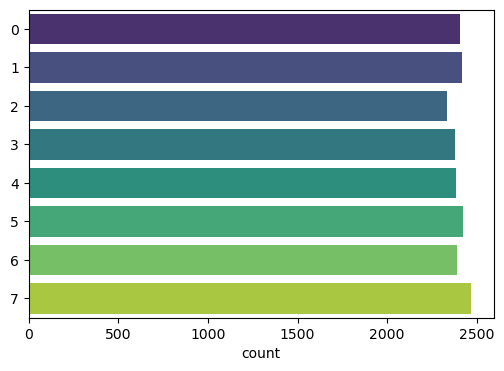

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(y=y_train, palette='viridis')

Print training data examples:


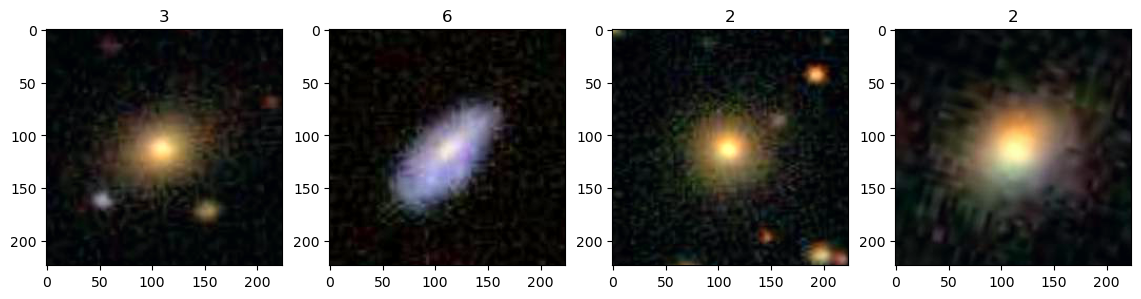

In [16]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])


In [17]:
epochs_num = 50
input_shape = (None, 224, 224, 3)
input_shape_alt = (224, 224, 3)

In [18]:
#plot the history of the model
def model_history_plot(model):
    hist = model.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

#plot the confusion matrix of the model
def plot_confusion(model, x, y):
    predictions = model.predict(X_test)
    predictions = tf.argmax(predictions, axis=-1)

    cm = tf.math.confusion_matrix(y_test, predictions)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    sns.heatmap(
        cm, annot=True,)
    plt.xlabel("Predicted")
    plt.ylabel("True")


In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_alt)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(class_num, activation='softmax')(x)

res_model = Model(inputs=base_model.input, outputs=predictions)
res_model.summary()

res_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy']) 



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [20]:
history_res = res_model.fit(X_train, y_train,
                    epochs=epochs_num, 
                    validation_data=(X_val, y_val), shuffle=True
)

Epoch 1/20


600/600 [==============================] - 723s 1s/step - loss: 1.6427 - accuracy: 0.3681 - val_loss: 3.1434 - val_accuracy: 0.1206
Epoch 2/20
600/600 [==============================] - 698s 1s/step - loss: 1.3760 - accuracy: 0.4718 - val_loss: 1.6957 - val_accuracy: 0.3569
Epoch 3/20
600/600 [==============================] - 699s 1s/step - loss: 1.2600 - accuracy: 0.5235 - val_loss: 2.1143 - val_accuracy: 0.3469
Epoch 4/20
600/600 [==============================] - 698s 1s/step - loss: 1.1782 - accuracy: 0.5560 - val_loss: 1.3474 - val_accuracy: 0.4866
Epoch 5/20
600/600 [==============================] - 698s 1s/step - loss: 1.0932 - accuracy: 0.5905 - val_loss: 1.8029 - val_accuracy: 0.4091
Epoch 6/20
600/600 [==============================] - 698s 1s/step - loss: 0.9892 - accuracy: 0.6301 - val_loss: 2.1299 - val_accuracy: 0.3519
Epoch 7/20
600/600 [==============================] - 698s 1s/step - loss: 0.8690 - accuracy: 0.6806 - val_loss: 1.6409 - val_accuracy: 0.44

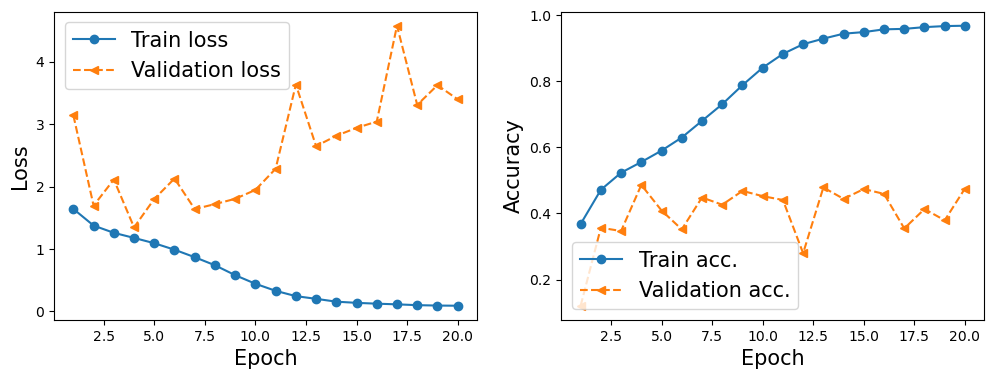

In [21]:
model_history_plot(history_res)

100/100 [==============================] - 37s 367ms/step


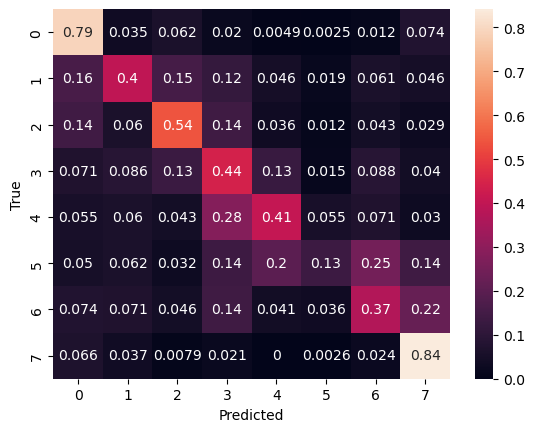

In [22]:
plot_confusion(res_model, X_test, y_test)

In [23]:
#create a feed forward model to show performance

fnn_model = tf.keras.Sequential()

fnn_model.add(tf.keras.layers.Flatten()) 
fnn_model.add(tf.keras.layers.Dense(units=256,name='fc_1', activation='relu'))
fnn_model.add(tf.keras.layers.BatchNormalization())
fnn_model.add(tf.keras.layers.Dense(units=512, name='fc_2', activation='relu'))    
fnn_model.add(tf.keras.layers.BatchNormalization())
fnn_model.add(tf.keras.layers.Dense(units=256,name='fc_3', activation='relu'))
fnn_model.add(tf.keras.layers.BatchNormalization())
fnn_model.add(tf.keras.layers.Dense(units=128,name='fc_4', activation='relu'))
fnn_model.add(tf.keras.layers.Dropout(rate=0.5))   
# add the last fully connected layer
fnn_model.add(tf.keras.layers.Dense(units=class_num, name='fc_5',activation='softmax'))

fnn_model.build(input_shape=input_shape)
fnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 fc_1 (Dense)                (None, 256)               38535424  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 fc_2 (Dense)                (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 fc_3 (Dense)                (None, 256)               1

In [24]:
fnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy']) 

In [25]:
history_fnn = fnn_model.fit(X_train, y_train,
                    epochs=epochs_num, 
                    validation_data=(X_val, y_val), shuffle=True
)

Epoch 1/20
600/600 [==============================] - 65s 107ms/step - loss: 1.9618 - accuracy: 0.2677 - val_loss: 1.9950 - val_accuracy: 0.2106
Epoch 2/20
600/600 [==============================] - 64s 106ms/step - loss: 1.7475 - accuracy: 0.3312 - val_loss: 3.8536 - val_accuracy: 0.1219
Epoch 3/20
600/600 [==============================] - 63s 106ms/step - loss: 1.6623 - accuracy: 0.3565 - val_loss: 2.2743 - val_accuracy: 0.1844
Epoch 4/20
600/600 [==============================] - 63s 106ms/step - loss: 1.6393 - accuracy: 0.3639 - val_loss: 1.8207 - val_accuracy: 0.2937
Epoch 5/20
600/600 [==============================] - 63s 106ms/step - loss: 1.6107 - accuracy: 0.3748 - val_loss: 3.2624 - val_accuracy: 0.2053
Epoch 6/20
600/600 [==============================] - 63s 106ms/step - loss: 1.5395 - accuracy: 0.4098 - val_loss: 17.8401 - val_accuracy: 0.1287
Epoch 7/20
600/600 [==============================] - 63s 106ms/step - loss: 1.4970 - accuracy: 0.4253 - val_loss: 1.7583 - val_a

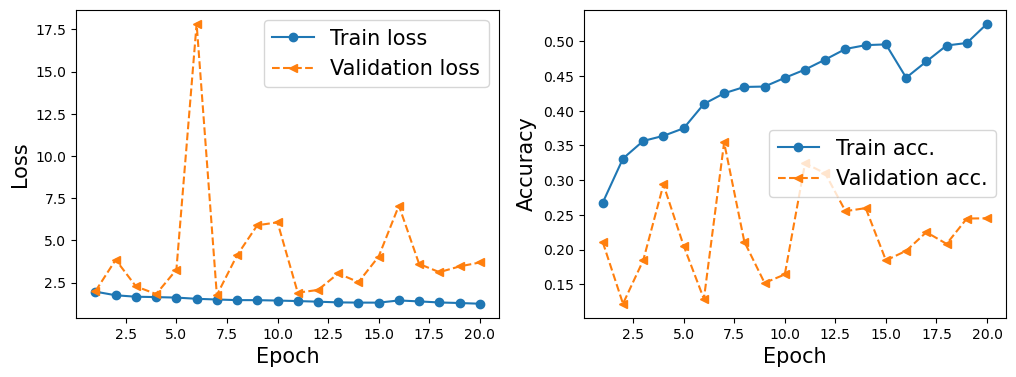

In [26]:
model_history_plot(history_fnn)

100/100 [==============================] - 1s 7ms/step


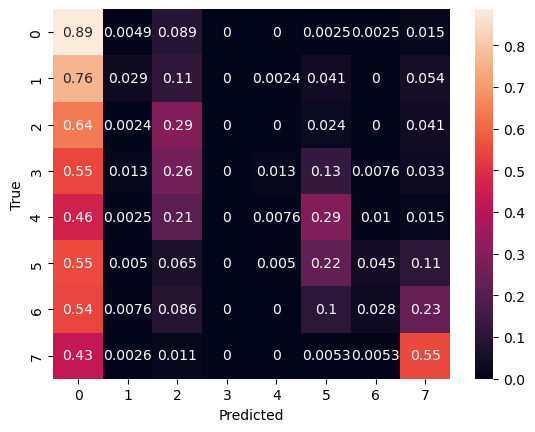

In [27]:
plot_confusion(fnn_model, X_test, y_test)

CNN MODEL

In [28]:
cnn_model = tf.keras.Sequential()


# -------------------------------------------------------
# add first convolution layer to the model, a pooling layer, then batch normalization
cnn_model.add(tf.keras.layers.RandomRotation(factor=(-0.5, 0.5), name = 'rot'))
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', data_format='channels_last', name='conv_1', activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# -------------------------------------------------------
# add 2nd convolution layer to the model, a pooling layer, then batch normalization
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', data_format='channels_last', name='conv_2', activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# -------------------------------------------------------
# add 3rd convolution layer to the model, a pooling layer, then batch normalization
cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', data_format='channels_last', name='conv_3', activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# -------------------------------------------------------
# add a fully connected layer (need to flatten the output of the previous layers first)
cnn_model.add(tf.keras.layers.Flatten()) 

cnn_model.add(tf.keras.layers.Dense(units=2048,name='fc_1', activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.Dense(units=1024, name='fc_2', activation='relu'))    
cnn_model.add(tf.keras.layers.Dropout(rate=0.5))  

# add the last fully connected layer
cnn_model.add(tf.keras.layers.Dense(units=class_num, name='fc_3',activation='softmax'))

# build model and print summary
tf.random.set_seed(1)
cnn_model.build(input_shape=input_shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot (RandomRotation)        (None, 224, 224, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 56, 56, 32)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 56, 56, 32)        128       
 chNormalization)                                                
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 28, 28, 64)        0         
                                                      

In [29]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy']) 

In [30]:
# Train the model
history_cnn = cnn_model.fit(X_train, y_train,
                    epochs=epochs_num, 
                    validation_data=(X_val, y_val), shuffle=True
)

Epoch 1/20


600/600 [==============================] - 137s 226ms/step - loss: 2.8480 - accuracy: 0.2654 - val_loss: 2.1703 - val_accuracy: 0.1875
Epoch 2/20
600/600 [==============================] - 135s 225ms/step - loss: 1.6848 - accuracy: 0.3660 - val_loss: 1.7267 - val_accuracy: 0.3650
Epoch 3/20
600/600 [==============================] - 134s 224ms/step - loss: 1.5769 - accuracy: 0.3938 - val_loss: 1.7813 - val_accuracy: 0.3644
Epoch 4/20
600/600 [==============================] - 134s 224ms/step - loss: 1.5396 - accuracy: 0.4064 - val_loss: 1.7146 - val_accuracy: 0.3537
Epoch 5/20
600/600 [==============================] - 134s 224ms/step - loss: 1.5201 - accuracy: 0.4196 - val_loss: 1.9220 - val_accuracy: 0.3394
Epoch 6/20
600/600 [==============================] - 135s 224ms/step - loss: 1.5044 - accuracy: 0.4240 - val_loss: 1.7599 - val_accuracy: 0.3928
Epoch 7/20
600/600 [==============================] - 134s 224ms/step - loss: 1.4767 - accuracy: 0.4352 - val_loss: 2.0689 - val_accura

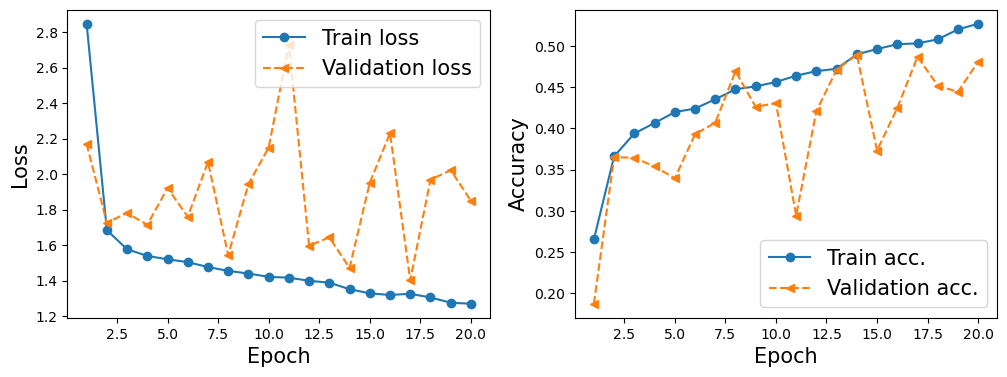

In [31]:
model_history_plot(history_cnn)

In [32]:
print("Evaluate on test data")
results = cnn_model.evaluate(X_test, y_test, batch_size=128)

Evaluate on test data
25/25 [==============================] - 3s 120ms/step - loss: 1.7253 - accuracy: 0.4859


100/100 [==============================] - 5s 33ms/step


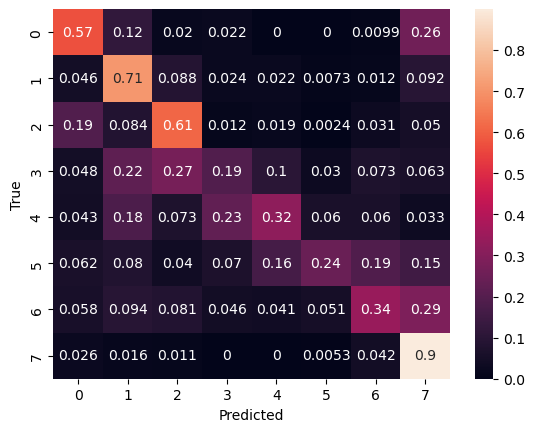

In [33]:
plot_confusion(cnn_model, X_test, y_test)

*LSTM MODEL*

In [34]:
LSTM_model = tf.keras.Sequential()
# define CNN model that will feed into LSTM
LSTM_model.add(tf.keras.layers.Reshape(target_shape=(1, 224, 224, 3)))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.RandomRotation(factor=(-0.5, 0.5)), batch_size=32,name = 'rot'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D (filters=32, kernel_size=(3, 3),strides=(2, 2),padding='same', activation='relu', input_shape=(None,32,128,128,3)), batch_size=32,name = 'c1'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(pool_size=(2, 2)), batch_size=32,name = 'p1'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), batch_size=32,name = 'bn1'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D (filters=64, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu', input_shape=(None,32,128,128,3)), batch_size=32,name = 'c2'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(pool_size=(2, 2)), batch_size=32,name = 'p2'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), batch_size=32,name = 'bn2'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D (filters=128, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu', input_shape=(None,32,128,128,3)), batch_size=32,name = 'c3'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(pool_size=(2, 2)), batch_size=32,name = 'p3'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization(), batch_size=32,name = 'bn3'))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten(), batch_size=32,name = 'flat'))

# define LSTM model
LSTM_model.add(tf.keras.layers.LSTM (units=256, activation = 'tanh',name = 'lstm'))
LSTM_model.add(tf.keras.layers.Dense(units=class_num,activation='softmax',name = 'dense'))

LSTM_model.build(input_shape=(None, 1, 224, 224, 3))

LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 224, 224, 3)    0         
                                                                 
 rot (TimeDistributed)       (None, 1, 224, 224, 3)    0         
                                                                 
 c1 (TimeDistributed)        (None, 1, 112, 112, 32)   896       
                                                                 
 p1 (TimeDistributed)        (None, 1, 56, 56, 32)     0         
                                                                 
 bn1 (TimeDistributed)       (None, 1, 56, 56, 32)     128       
                                                                 
 c2 (TimeDistributed)        (None, 1, 56, 56, 64)     51264     
                                                                 
 p2 (TimeDistributed)        (None, 1, 28, 28, 64)    

In [35]:
LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy']) 

In [36]:
history_lstm = LSTM_model.fit(X_train, y_train,
                    epochs=epochs_num, 
                    validation_data=(X_val, y_val), shuffle=True
)

Epoch 1/20


600/600 [==============================] - 95s 157ms/step - loss: 1.8904 - accuracy: 0.2577 - val_loss: 1.9173 - val_accuracy: 0.2412
Epoch 2/20
600/600 [==============================] - 93s 155ms/step - loss: 1.8337 - accuracy: 0.2830 - val_loss: 1.9154 - val_accuracy: 0.2578
Epoch 3/20
600/600 [==============================] - 93s 155ms/step - loss: 1.8002 - accuracy: 0.2985 - val_loss: 2.0819 - val_accuracy: 0.1775
Epoch 4/20
600/600 [==============================] - 93s 155ms/step - loss: 1.7878 - accuracy: 0.2991 - val_loss: 1.8427 - val_accuracy: 0.2700
Epoch 5/20
600/600 [==============================] - 93s 155ms/step - loss: 1.7550 - accuracy: 0.3140 - val_loss: 2.2688 - val_accuracy: 0.1569
Epoch 6/20
600/600 [==============================] - 93s 154ms/step - loss: 1.7669 - accuracy: 0.3142 - val_loss: 2.3074 - val_accuracy: 0.1531
Epoch 7/20
600/600 [==============================] - 93s 154ms/step - loss: 1.7456 - accuracy: 0.3208 - val_loss: 1.7672 - val_accuracy: 0.2

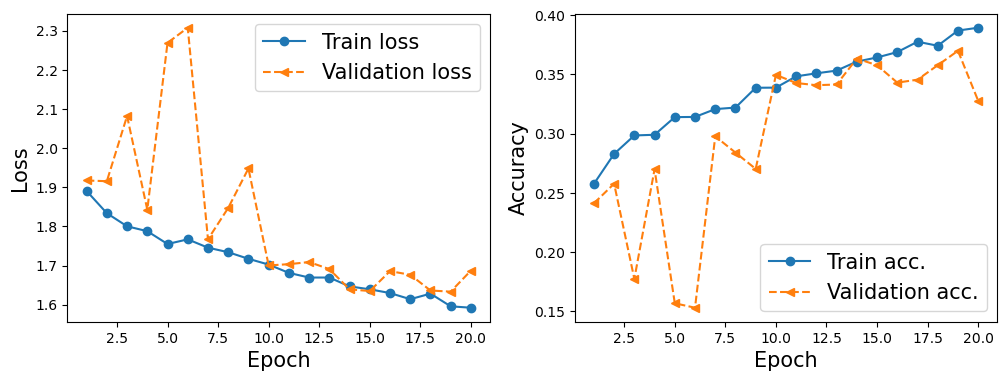

In [37]:
# plot history
model_history_plot(history_lstm)

In [38]:
print("Evaluate on test data")
results = LSTM_model.evaluate(X_test, y_test, batch_size=128)

Evaluate on test data
25/25 [==============================] - 3s 120ms/step - loss: 1.6804 - accuracy: 0.3366


100/100 [==============================] - 4s 34ms/step


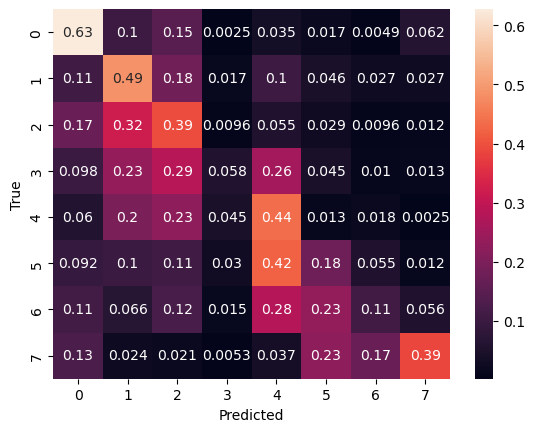

In [39]:
plot_confusion(LSTM_model, X_test, y_test)

In [42]:
#Save the models after training, and histories so they are not lost

res_model.save('res_model.keras')
fnn_model.save('fnn_model.keras')
cnn_model.save('cnn_model.keras')
LSTM_model.save('LSTM_model.keras')

hist_df_res = pd.DataFrame(history_res.history) 
hist_df_fnn = pd.DataFrame(history_fnn.history) 
hist_df_cnn = pd.DataFrame(history_cnn.history) 
hist_df_lstm = pd.DataFrame(history_lstm.history)

hist_csv_file = 'history_res.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_res.to_csv(f)

hist_csv_file = 'history_fnn.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_fnn.to_csv(f)

hist_csv_file = 'history_cnn.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_cnn.to_csv(f)

hist_csv_file = 'history_lstm.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_lstm.to_csv(f)

In [48]:
#Save the models after training, and histories so they are not lost
'''
res_model.save('res_model20.keras')
fnn_model.save('fnn_model20.keras')
cnn_model.save('cnn_model20.keras')
LSTM_model.save('LSTM_model20.keras')

hist_df_res = pd.DataFrame(history_res.history) 
hist_df_fnn = pd.DataFrame(history_fnn.history) 
hist_df_cnn = pd.DataFrame(history_cnn.history) 
hist_df_lstm = pd.DataFrame(history_lstm.history)

hist_csv_file = 'history_res20.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_res.to_csv(f)

hist_csv_file = 'history_fnn20.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_fnn.to_csv(f)

hist_csv_file = 'history_cnn20.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_cnn.to_csv(f)

hist_csv_file = 'history_lstm20.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df_lstm.to_csv(f)'''

"\nres_model.save('res_model20.keras')\nfnn_model.save('fnn_model20.keras')\ncnn_model.save('cnn_model20.keras')\nLSTM_model.save('LSTM_model20.keras')\n\nhist_df_res = pd.DataFrame(history_res.history) \nhist_df_fnn = pd.DataFrame(history_fnn.history) \nhist_df_cnn = pd.DataFrame(history_cnn.history) \nhist_df_lstm = pd.DataFrame(history_lstm.history)\n\nhist_csv_file = 'history_res20.csv'\nwith open(hist_csv_file, mode='w') as f:\n    hist_df_res.to_csv(f)\n\nhist_csv_file = 'history_fnn20.csv'\nwith open(hist_csv_file, mode='w') as f:\n    hist_df_fnn.to_csv(f)\n\nhist_csv_file = 'history_cnn20.csv'\nwith open(hist_csv_file, mode='w') as f:\n    hist_df_cnn.to_csv(f)\n\nhist_csv_file = 'history_lstm20.csv'\nwith open(hist_csv_file, mode='w') as f:\n    hist_df_lstm.to_csv(f)"